## AnimeGANv2


AnimeGANv2 is a pre-trained vgg199 model which is a combination of a neural style transfer and GAN.

This version has 4 types: Hayao style v1, Hayao style v2, Shinkai stlye and Paprika style. 

To use it, just need to choose the style and press the button to upload

In [1]:
#@title Install and download. Run once.
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1VPAPI84qaPUCHKHJLHiMK7BP_JE66xNe' -O AnimeGAN_Hayao.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17XRNQgQoUAnu6SM5VgBuhqSBO4UAVNI1' -O AnimeGANv2_Hayao.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=10rQfe4obW0dkNtsQuWg-szC4diBzYFXK' -O AnimeGANv2_Shinkai.onnx
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1X3Glf69Ter_n2Tj6p81VpGKx7U4Dq-tI' -O AnimeGANv2_Paprika.onnx

!pip -qq install opencv-python
!pip -qq install numpy
!pip -qq install onnxruntime-gpu
!pip install ffmpeg


--2023-02-24 21:06:28--  https://docs.google.com/uc?export=download&id=1VPAPI84qaPUCHKHJLHiMK7BP_JE66xNe
Resolving docs.google.com (docs.google.com)... 172.253.117.100, 172.253.117.102, 172.253.117.139, ...
Connecting to docs.google.com (docs.google.com)|172.253.117.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kcmmposoib14kdlbgelmqhquer39jkot/1677272775000/00710070147634057709/*/1VPAPI84qaPUCHKHJLHiMK7BP_JE66xNe?e=download&uuid=f8e53bce-e02f-4ecf-9c88-0695710ee54f [following]
--2023-02-24 21:06:29--  https://doc-14-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kcmmposoib14kdlbgelmqhquer39jkot/1677272775000/00710070147634057709/*/1VPAPI84qaPUCHKHJLHiMK7BP_JE66xNe?e=download&uuid=f8e53bce-e02f-4ecf-9c88-0695710ee54f
Resolving doc-14-70-docs.googleusercontent.com (doc-14-70-docs.googleusercontent.com)... 74.125.142.132, 2607:f

/content/in


Saving stata.jpg to stata.jpg


  0%|          | 0/1 [00:00<?, ?it/s]

updating: content/outputs/stata.jpg (deflated 0%)


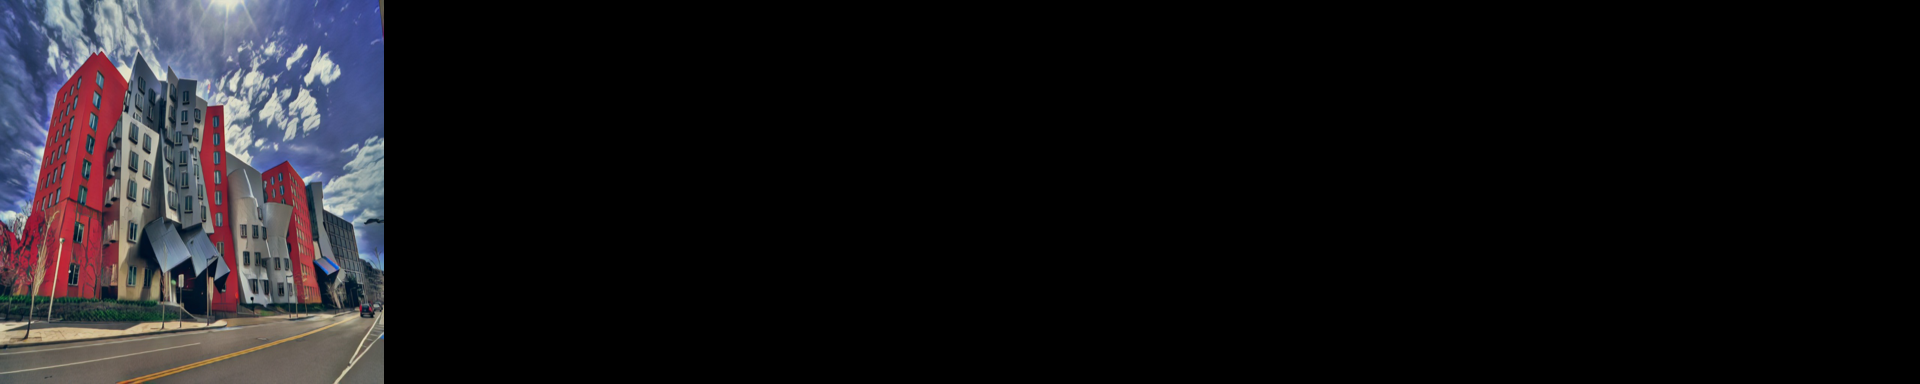

In [4]:
#@title Define functions
#@markdown Select model version and run.
import onnxruntime as ort
import time, cv2, PIL
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


pic_form = ['.jpeg','.jpg','.png','.JPEG','.JPG','.PNG']
device_name = ort.get_device()

if device_name == 'cpu':
    providers = ['CPUExecutionProvider']
elif device_name == 'GPU':
    providers = ['CUDAExecutionProvider', 'CPUExecutionProvider']

model = 'AnimeGANv2_Paprika' #@param ['AnimeGAN_Hayao','AnimeGANv2_Hayao','AnimeGANv2_Shinkai','AnimeGANv2_Paprika']
#load model
session = ort.InferenceSession(f'/content/{model}.onnx', providers=providers)

def process_image(img, x32=True):
    h, w = img.shape[:2]
    if x32: # resize image to multiple of 32s
        def to_32s(x):
            return 256 if x < 256 else x - x%32
        img = cv2.resize(img, (to_32s(w), to_32s(h)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)/ 127.5 - 1.0
    return img

def load_test_data(image_path):
    img0 = cv2.imread(image_path).astype(np.float32)
    img = process_image(img0)
    img = np.expand_dims(img, axis=0)
    return img, img0.shape[:2]


def Convert(img, scale):
    x = session.get_inputs()[0].name
    y = session.get_outputs()[0].name
    fake_img = session.run(None, {x : img})[0]
    images = (np.squeeze(fake_img) + 1.) / 2 * 255
    images = np.clip(images, 0, 255).astype(np.uint8)
    output_image = cv2.resize(images, (scale[1],scale[0]))
    return cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
    

in_dir = '/content/in'
out_dir = f"/content/outputs"

#setup colab interface
from google.colab import files
import ipywidgets as widgets
from IPython.display import clear_output 
from IPython.display import display
import os
from glob import glob

def reset(p):
  with output_reset:
    clear_output()
  clear_output()
  process()
 
button_reset = widgets.Button(description="Upload")
output_reset = widgets.Output()
button_reset.on_click(reset)

 
def show_img(result_folder, size=384):
  line_img = PIL.Image.new('RGB', (size * 5, size), 0)
  col_num = 0
  for file_name in sorted(os.listdir(result_folder)):
    if file_name.endswith(".jpg"):
      image_result = PIL.Image.open(os.path.join(result_folder, file_name))
      image_result = image_result.resize((size,size))
      line_img.paste(image_result, (col_num * size, 0))
      col_num += 1
      if col_num == 5:
        display(line_img)
        line_img = PIL.Image.new('RGB', (size * 5, size), 0)
        col_num = 0
  if col_num != 0:
    display(line_img)


def process(upload=True):
  os.makedirs(in_dir, exist_ok=True)
  %cd {in_dir}/
  %rm -rf {out_dir}/*
  os.makedirs(out_dir, exist_ok=True)
  in_files = sorted(glob(f'{in_dir}/*'))
  if (len(in_files)==0) | (upload):
    %rm -rf {in_dir}/*
    uploaded = files.upload()
    if len(uploaded.keys())<=0: 
      print('\nNo files were uploaded. Try again..\n')
      return
  
  # Process the uploaded image.
  in_files = sorted(glob(f'{in_dir}/*'))
  in_files = [ x for x in in_files if os.path.splitext(x)[-1] in pic_form]
  for ims in tqdm(in_files):
    out_name = f"{out_dir}/{ims.split('/')[-1].split('.')[0]}.jpg"
    mat, scale = load_test_data(ims) 
    res = Convert(mat, scale)
    cv2.imwrite(out_name, res)

  # Get the compressed package of the output results
  out_zip = f"{out_dir}.zip"
  !zip {out_zip} {out_dir}/*
    
  # Visualize the result picture
  show_img(out_dir)


process()

# Neural style transfer

Neural style transfer is a pre-trained model named arbitrary image stylization v1-256.

To use it, first upload the content photo then a style photo.


In [13]:
#@title Define functions

from io import BytesIO
import tensorflow_hub as hub
import PIL
import cv2
from PIL import Image

import numpy as np
import tensorflow as tf
import ipywidgets as widgets
import IPython.display as display
import matplotlib.pyplot as plt
from google.colab import files

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')


button = widgets.Button(description="Start")
output = widgets.Output()


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


def run(b):
    button.disabled = True

    with output:
        display.clear_output()
    
    uploaded_1 = files.upload()
    uploaded_2 = files.upload()

    for fname in uploaded_1:
      bytes_in_1_name = fname

    for fname in uploaded_2:
      bytes_in_2_name = fname

    content_image = load_img(bytes_in_1_name)
    style_image = load_img(bytes_in_2_name)
    
    im_out = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
    out_image = tensor_to_image(im_out)
    out_image.save("out_put_img.jpg")
    

    plt.imshow(out_image)
    plt.title('Transfered image')

    button.disabled = False



Button(description='Start', style=ButtonStyle())

Saving stata.jpg to stata (4).jpg


Saving udnie.jpg to udnie (3).jpg


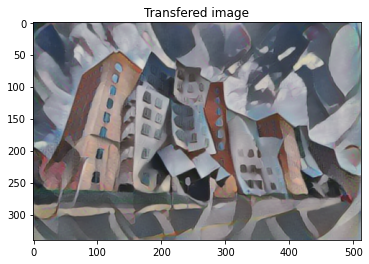

In [14]:
#@title Run
button.on_click(run)
display.display(button)

# Try to use the camera

In [5]:
#@title Capture video
from IPython.display import display, Javascript,HTML
from google.colab.output import eval_js
from base64 import b64decode
def record_video(filename):
  js=Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      
      capture.textContent = "Start Recording";
      capture.style.background = "orange";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({audio:true, video: true});
    
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;
      video.muted = true;

      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);

      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();
      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      
      // stop the stream and remove the video element
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
    return btoa(binaryString);
    }
  """)
  try:
    display(js)
    data=eval_js('recordVideo({})')
    binary=b64decode(data)
    with open(filename,"wb") as video_file:
      video_file.write(binary)
    print(f"Finished recording video at:{filename}")
  except Exception as err:
    print(str(err))
  


In [6]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):
  
  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")


video_path = "test.mp4"
record_video(video_path)
show_video(video_path)

<IPython.core.display.Javascript object>

Finished recording video at:test.mp4


In [7]:
#@title Changing to mp4
import ffmpeg
import os, sys, re
video_file_path = "/content/in/test.mp4" #@param {type:"string"}

output_file_path = re.search("^[\/].+\/", video_file_path)
output_file_path_raw = output_file_path.group(0)
delsplit = re.search("\/(?:.(?!\/))+$", video_file_path)
filename = re.sub("^[\/]", "", delsplit.group(0))
filename_raw = re.sub(".{4}$", "", filename)
file_extension = re.search(".{3}$", filename)
file_extension_raw = file_extension.group(0)

os.environ['inputFile'] = video_file_path
os.environ['outputPath'] = output_file_path_raw
os.environ['fileName'] = filename_raw
os.environ['fileExtension'] = file_extension_raw

!ffmpeg -hide_banner -i "$inputFile" -c copy -strict -2 "$outputPath"/"input_video".mp4

Input #0, matroska,webm, from '/content/in/test.mp4':
  Metadata:
    encoder         : Opera
  Duration: N/A, start: 0.000000, bitrate: N/A
    Stream #0:0(eng): Audio: opus, 48000 Hz, mono, fltp (default)
    Stream #0:1(eng): Video: vp9 (Profile 0), yuv420p(tv, unknown/bt709/iec61966-2-1), 640x480, SAR 1:1 DAR 4:3, 1k tbr, 1k tbn, 1k tbc (default)
    Metadata:
      alpha_mode      : 1
[mp4 @ 0x561b4e1feb40] track 1: codec frame size is not set
Output #0, mp4, to '/content/in//input_video.mp4':
  Metadata:
    encoder         : Lavf58.29.100
    Stream #0:0(eng): Video: vp9 (Profile 0) (vp09 / 0x39307076), yuv420p(tv, unknown/bt709/iec61966-2-1), 640x480 [SAR 1:1 DAR 4:3], q=2-31, 1k tbr, 16k tbn, 1k tbc (default)
    Metadata:
      alpha_mode      : 1
    Stream #0:1(eng): Audio: opus (Opus / 0x7375704F), 48000 Hz, mono, fltp (default)
Stream mapping:
  Stream #0:1 -> #0:0 (copy)
  Stream #0:0 -> #0:1 (copy)
Press [q] to stop, [?] for help
frame=  143 fps=0.0 q=-1.0 Lsize=     66

# Neural transfer for video

In [8]:
#@title Import
!git clone https://github.com/westgarthb/style-transfer-video-processor
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow_hub as hub
import numpy as np
import tensorflow as tf
import glob
import cv2
import logging

Cloning into 'style-transfer-video-processor'...
remote: Enumerating objects: 221, done.
remote: Total 221 (delta 0), reused 0 (delta 0), pack-reused 221
Receiving objects: 100% (221/221), 54.21 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [9]:
#@title Config
class Config:
    ROOT_PATH = '/content/in/style-transfer-video-processor'
    # defines the maximum height dimension in pixels. Used for down-sampling the video frames
    FRAME_HEIGHT = 360
    CLEAR_INPUT_FRAME_CACHE = True
    # defines the rate at which you want to capture frames from the input video
    INPUT_FPS = 20
    INPUT_VIDEO_NAME = 'input_video.mp4'
    INPUT_VIDEO_PATH = f'{ROOT_PATH}/{INPUT_VIDEO_NAME}'
    INPUT_FRAME_DIRECTORY = f'{ROOT_PATH}/input_frames'
    INPUT_FRAME_FILE = '{:0>4d}_frame.png'
    INPUT_FRAME_PATH = f'{INPUT_FRAME_DIRECTORY}/{INPUT_FRAME_FILE}'

    STYLE_REF_DIRECTORY = f'{ROOT_PATH}/style_ref'
    # defines the reference style image transition sequence. Values correspond to indices in STYLE_REF_DIRECTORY
    # add None in the sequence to NOT apply style transfer for part of the video (ie. [None, 0, 1, 2])  
    STYLE_SEQUENCE = [0,None,1,None,2]

    OUTPUT_FPS = 20
    OUTPUT_VIDEO_NAME = 'output_video.mp4'
    OUTPUT_VIDEO_PATH = f'{ROOT_PATH}/{OUTPUT_VIDEO_NAME}'
    OUTPUT_FRAME_DIRECTORY = f'{ROOT_PATH}/output_frames'
    OUTPUT_FRAME_FILE = '{:0>4d}_frame.png'
    OUTPUT_FRAME_PATH = f'{OUTPUT_FRAME_DIRECTORY}/{OUTPUT_FRAME_FILE}'

    GHOST_FRAME_TRANSPARENCY = 0.05
    PRESERVE_COLORS = False

    TENSORFLOW_CACHE_DIRECTORY = f'{ROOT_PATH}/tensorflow_cache'
    TENSORFLOW_HUB_HANDLE = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'

In [10]:
#@title Run
class StyleFrame:

    MAX_CHANNEL_INTENSITY = 255.0

    def __init__(self, conf=Config):
        self.conf = conf
        os.environ['TFHUB_CACHE_DIR'] = self.conf.TENSORFLOW_CACHE_DIRECTORY
        self.hub_module = hub.load(self.conf.TENSORFLOW_HUB_HANDLE)
        self.input_frame_directory = glob.glob(f'{self.conf.INPUT_FRAME_DIRECTORY}/*')
        self.output_frame_directory = glob.glob(f'{self.conf.OUTPUT_FRAME_DIRECTORY}/*')
        self.style_directory = glob.glob(f'{self.conf.STYLE_REF_DIRECTORY}/*')
        self.ref_count = len(self.conf.STYLE_SEQUENCE)

        files_to_be_cleared = self.output_frame_directory
        if self.conf.CLEAR_INPUT_FRAME_CACHE:
            files_to_be_cleared += self.input_frame_directory
        
        for file in files_to_be_cleared:
            os.remove(file)
        
        # Update contents of directory after deletion
        self.input_frame_directory = glob.glob(f'{self.conf.INPUT_FRAME_DIRECTORY}/*')
        self.output_frame_directory = glob.glob(f'{self.conf.OUTPUT_FRAME_DIRECTORY}/*')

        if len(self.input_frame_directory):
            # Retrieve an image in the input frame dir to get the width
            self.frame_width = cv2.imread(self.input_frame_directory[0]).shape[1]

    def get_input_frames(self):
        if len(self.input_frame_directory):
            print("Using cached input frames")
            return
        vid_obj = cv2.VideoCapture(self.conf.INPUT_VIDEO_PATH)
        frame_interval = np.floor((1.0 / self.conf.INPUT_FPS) * 1000)
        success, image = vid_obj.read()
        if image is None:
            raise ValueError(f"ERROR: Please provide missing video: {self.conf.INPUT_VIDEO_PATH}")
        scale_constant = (self.conf.FRAME_HEIGHT / image.shape[0])
        self.frame_width = int(image.shape[1] * scale_constant)
        image = cv2.resize(image, (self.frame_width, self.conf.FRAME_HEIGHT))
        cv2.imwrite(self.conf.INPUT_FRAME_PATH.format(0), image.astype(np.uint8))

        count = 1
        while success:
            msec_timestamp = count * frame_interval
            vid_obj.set(cv2.CAP_PROP_POS_MSEC, msec_timestamp)
            success, image = vid_obj.read()
            if not success:
                break
            image = cv2.resize(image, (self.frame_width, self.conf.FRAME_HEIGHT))
            cv2.imwrite(self.conf.INPUT_FRAME_PATH.format(count), image.astype(np.uint8))
            count += 1
        self.input_frame_directory = glob.glob(f'{self.conf.INPUT_FRAME_DIRECTORY}/*')

    def get_style_info(self):
        frame_length = len(self.input_frame_directory)
        style_refs = list()
        resized_ref = False
        style_files = sorted(self.style_directory)
        self.t_const = frame_length if self.ref_count == 1 else np.ceil(frame_length / (self.ref_count - 1))

        # Open first style ref and force all other style refs to match size
        first_style_ref = cv2.imread(style_files.pop(0))
        first_style_ref = cv2.cvtColor(first_style_ref, cv2.COLOR_BGR2RGB)
        first_style_height, first_style_width, _rgb = first_style_ref.shape
        style_refs.append(first_style_ref / self.MAX_CHANNEL_INTENSITY)

        for filename in style_files:
            style_ref = cv2.imread(filename)
            style_ref = cv2.cvtColor(style_ref, cv2.COLOR_BGR2RGB)
            style_ref_height, style_ref_width, _rgb = style_ref.shape
            # Resize all style_ref images to match first style_ref dimensions
            if style_ref_width != first_style_width or style_ref_height != first_style_height:
                resized_ref = True
                style_ref = cv2.resize(style_ref, (first_style_width, first_style_height))
            style_refs.append(style_ref / self.MAX_CHANNEL_INTENSITY)

        if resized_ref:
            print("WARNING: Resizing style images which may cause distortion. To avoid this, please provide style images with the same dimensions")

        self.transition_style_seq = list()
        for i in range(self.ref_count):
            if self.conf.STYLE_SEQUENCE[i] is None:
                self.transition_style_seq.append(None)
            else:
                self.transition_style_seq.append(style_refs[self.conf.STYLE_SEQUENCE[i]])

    def _trim_img(self, img):
        return img[:self.conf.FRAME_HEIGHT, :self.frame_width]

    def get_output_frames(self):
        self.input_frame_directory = glob.glob(f'{self.conf.INPUT_FRAME_DIRECTORY}/*')
        ghost_frame = None
        for count, filename in enumerate(sorted(self.input_frame_directory)):
            if count % 10 == 0:
                print(f"Output frame: {(count/len(self.input_frame_directory)):.0%}")
            content_img = cv2.imread(filename) 
            content_img = cv2.cvtColor(content_img, cv2.COLOR_BGR2RGB) / self.MAX_CHANNEL_INTENSITY
            curr_style_img_index = int(count / self.t_const)
            mix_ratio = 1 - ((count % self.t_const) / self.t_const)
            inv_mix_ratio = 1 - mix_ratio

            prev_image = self.transition_style_seq[curr_style_img_index]
            next_image = self.transition_style_seq[curr_style_img_index + 1]
            
            prev_is_content_img = False
            next_is_content_img = False
            if prev_image is None:
                prev_image = content_img
                prev_is_content_img = True
            if next_image is None:
                next_image = content_img
                next_is_content_img = True
            # If both, don't need to apply style transfer
            if prev_is_content_img and next_is_content_img:
                temp_ghost_frame = cv2.cvtColor(ghost_frame, cv2.COLOR_RGB2BGR) * self.MAX_CHANNEL_INTENSITY
                cv2.imwrite(self.conf.OUTPUT_FRAME_PATH.format(count), temp_ghost_frame)
                continue
            
            if count > 0:
                content_img = ((1 - self.conf.GHOST_FRAME_TRANSPARENCY) * content_img) + (self.conf.GHOST_FRAME_TRANSPARENCY * ghost_frame)
            content_img = tf.cast(tf.convert_to_tensor(content_img), tf.float32)

            if prev_is_content_img:
                blended_img = next_image
            elif next_is_content_img:
                blended_img = prev_image
            else:
                prev_style = mix_ratio * prev_image
                next_style = inv_mix_ratio * next_image
                blended_img = prev_style + next_style

            blended_img = tf.cast(tf.convert_to_tensor(blended_img), tf.float32)
            expanded_blended_img = tf.constant(tf.expand_dims(blended_img, axis=0))
            expanded_content_img = tf.constant(tf.expand_dims(content_img, axis=0))
            # Apply style transfer
            stylized_img = self.hub_module(expanded_content_img, expanded_blended_img).pop()
            stylized_img = tf.squeeze(stylized_img)

            # Re-blend
            if prev_is_content_img:
                prev_style = mix_ratio * content_img
                next_style = inv_mix_ratio * stylized_img
            if next_is_content_img:
                prev_style = mix_ratio * stylized_img
                next_style = inv_mix_ratio * content_img
            if prev_is_content_img or next_is_content_img:
                stylized_img = self._trim_img(prev_style) + self._trim_img(next_style)

            if self.conf.PRESERVE_COLORS:
                stylized_img = self._color_correct_to_input(content_img, stylized_img)
            
            ghost_frame = np.asarray(self._trim_img(stylized_img))

            temp_ghost_frame = cv2.cvtColor(ghost_frame, cv2.COLOR_RGB2BGR) * self.MAX_CHANNEL_INTENSITY
            cv2.imwrite(self.conf.OUTPUT_FRAME_PATH.format(count), temp_ghost_frame)
        self.output_frame_directory = glob.glob(f'{self.conf.OUTPUT_FRAME_DIRECTORY}/*')

    def _color_correct_to_input(self, content, generated):
        # image manipulations for compatibility with opencv
        content = np.array((content * self.MAX_CHANNEL_INTENSITY), dtype=np.float32)
        content = cv2.cvtColor(content, cv2.COLOR_BGR2YCR_CB)
        generated = np.array((generated * self.MAX_CHANNEL_INTENSITY), dtype=np.float32)
        generated = cv2.cvtColor(generated, cv2.COLOR_BGR2YCR_CB)
        generated = self._trim_img(generated)
        # extract channels, merge intensity and color spaces
        color_corrected = np.zeros(generated.shape, dtype=np.float32)
        color_corrected[:, :, 0] = generated[:, :, 0]
        color_corrected[:, :, 1] = content[:, :, 1]
        color_corrected[:, :, 2] = content[:, :, 2]
        return cv2.cvtColor(color_corrected, cv2.COLOR_YCrCb2BGR) / self.MAX_CHANNEL_INTENSITY


    def create_video(self):
        self.output_frame_directory = glob.glob(f'{self.conf.OUTPUT_FRAME_DIRECTORY}/*')
        fourcc = cv2.VideoWriter_fourcc(*'MP4V')
        video_writer = cv2.VideoWriter(self.conf.OUTPUT_VIDEO_PATH, fourcc, self.conf.OUTPUT_FPS, (self.frame_width, self.conf.FRAME_HEIGHT))

        for count, filename in enumerate(sorted(self.output_frame_directory)):
            if count % 10 == 0:
                print(f"Saving frame: {(count/len(self.output_frame_directory)):.0%}")
            image = cv2.imread(filename)
            video_writer.write(image)

        video_writer.release()
        print(f"Style transfer complete! Output at {self.conf.OUTPUT_VIDEO_PATH}")

    def run(self):
        print("Getting input frames")
        self.get_input_frames()
        print("Getting style info")
        self.get_style_info()
        print("Getting output frames")
        self.get_output_frames()
        print("Saving video")
        self.create_video()

if __name__ == "__main__":
    StyleFrame().run()


Getting input frames
Getting style info
Getting output frames
Output frame: 0%
Output frame: 11%
Output frame: 21%
Output frame: 32%
Output frame: 42%
Output frame: 53%
Output frame: 63%
Output frame: 74%
Output frame: 84%
Output frame: 95%
Saving video
Saving frame: 0%
Saving frame: 11%
Saving frame: 21%
Saving frame: 32%
Saving frame: 42%
Saving frame: 53%
Saving frame: 63%
Saving frame: 74%
Saving frame: 84%
Saving frame: 95%
Style transfer complete! Output at /content/in/style-transfer-video-processor/output_video.mp4
